<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/NLPModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None

In [ ]:
!pip install nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
full_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/twitter_sen/twcs/twcs.csv", nrows=100000)
df = full_df[["text"]]
df["text"] = df["text"].astype(str)
full_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [ ]:
# Low casting(대문자 데이터를 전부 소문자 데이터로 변경)
df["text_lower"] = df["text"].str.lower()
df.head()

,text,text_lower
0,@115712 I understand. I would like to assist y...,@115712 i understand. i would like to assist y...
1,@sprintcare and how do you propose we do that,@sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messag...,@sprintcare i have sent several private messag...
3,@115712 Please send us a Private Message so th...,@115712 please send us a private message so th...
4,@sprintcare I did.,@sprintcare i did.


In [ ]:
# 특수기호를 제거
df.drop(["text_lower"], axis=1, inplace=True)

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text"].apply(lambda text: remove_punctuation(text))
df.head()

,text,text_wo_punct
0,@115712 I understand. I would like to assist y...,115712 I understand I would like to assist you...
1,@sprintcare and how do you propose we do that,sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messag...,sprintcare I have sent several private message...
3,@115712 Please send us a Private Message so th...,115712 Please send us a Private Message so tha...
4,@sprintcare I did.,sprintcare I did


In [ ]:
# 영어 불용어 제거
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,text,text_wo_punct,text_wo_stop
0,@115712 I understand. I would like to assist y...,115712 I understand I would like to assist you...,115712 I understand I would like assist We wou...
1,@sprintcare and how do you propose we do that,sprintcare and how do you propose we do that,sprintcare propose
2,@sprintcare I have sent several private messag...,sprintcare I have sent several private message...,sprintcare I sent several private messages one...
3,@115712 Please send us a Private Message so th...,115712 Please send us a Private Message so tha...,115712 Please send us Private Message assist J...
4,@sprintcare I did.,sprintcare I did,sprintcare I


In [ ]:
# 자주 사용하는 단어 삭제
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(10)

[('I', 31106),
 ('us', 15025),
 ('DM', 10010),
 ('help', 8705),
 ('Please', 7980),
 ('Hi', 7836),
 ('We', 7589),
 ('get', 7162),
 ('Thanks', 6197),
 ('please', 6125)]

In [ ]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

,text,text_wo_punct,text_wo_stop,text_wo_stopfreq
0,@115712 I understand. I would like to assist y...,115712 I understand I would like to assist you...,115712 I understand I would like assist We wou...,115712 understand would like assist would need...
1,@sprintcare and how do you propose we do that,sprintcare and how do you propose we do that,sprintcare propose,sprintcare propose
2,@sprintcare I have sent several private messag...,sprintcare I have sent several private message...,sprintcare I sent several private messages one...,sprintcare sent several private messages one r...
3,@115712 Please send us a Private Message so th...,115712 Please send us a Private Message so tha...,115712 Please send us Private Message assist J...,115712 send Private Message assist Just click ...
4,@sprintcare I did.,sprintcare I did,sprintcare I,sprintcare


In [ ]:
#희귀한 단어 삭제
df.drop(["text_wo_punct", "text_wo_stop"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,text,text_wo_stopfreq,text_wo_stopfreqrare
0,@115712 I understand. I would like to assist y...,115712 understand would like assist would need...,115712 understand would like assist would need...
1,@sprintcare and how do you propose we do that,sprintcare propose,sprintcare propose
2,@sprintcare I have sent several private messag...,sprintcare sent several private messages one r...,sprintcare sent several private messages one r...
3,@115712 Please send us a Private Message so th...,115712 send Private Message assist Just click ...,115712 send Private Message assist Just click ...
4,@sprintcare I did.,sprintcare,sprintcare


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# nltk의 VADER 감정 분석기를 다운로드합니다.
nltk.download('vader_lexicon')

# VADER SentimentIntensityAnalyzer를 초기화합니다.
analyzer = SentimentIntensityAnalyzer()

# 데이터프레임의 text 컬럼을 리스트로 변환
text_list = df["text_wo_stopfreqrare"].tolist()

# 감정 분석 결과를 저장할 리스트
labels = []

# VADER를 사용하여 감정 분석을 수행하고 결과를 레이블로 저장
# 긍정 : 0, 부정 : 1,
for text in text_list:
    # VADER는 감정 점수를 -1부터 1까지의 범위로 제공합니다.
    # compound 점수가 0.1보다 크면 긍정, -0.1보다 작으면 부정, 그렇지 않으면 중립으로 레이블링
    score = analyzer.polarity_scores(text)['compound']
    if score > 0.1:
        labels.append(0)
    elif score < 1:
        labels.append(1)

# 데이터프레임에 레이블 컬럼 추가
df["Emotional_labels"] = labels

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df[["text_wo_stopfreqrare", "Emotional_labels"]]

,text_wo_stopfreqrare,Emotional_labels
0,115712 understand would like assist would need...,0
1,sprintcare propose,1
2,sprintcare sent several private messages one r...,1
3,115712 send Private Message assist Just click ...,0
4,sprintcare,1
...,...,...
99995,144297 understand received different product o...,0
99996,AmazonHelp already raised issue see happen next,1
99997,144297 If youve shared details via link Well c...,0
99998,AmazonHelp It great ur side ur pre scripted n ...,0


In [ ]:
# text 열과 label 열의 중복을 제외한 값의 개수
df['text_wo_stopfreqrare'].nunique(), df['Emotional_labels'].nunique()

(99179, 2)

In [ ]:
# document 열의 중복 제거
df.drop_duplicates(subset=['text_wo_stopfreqrare'], inplace=True)

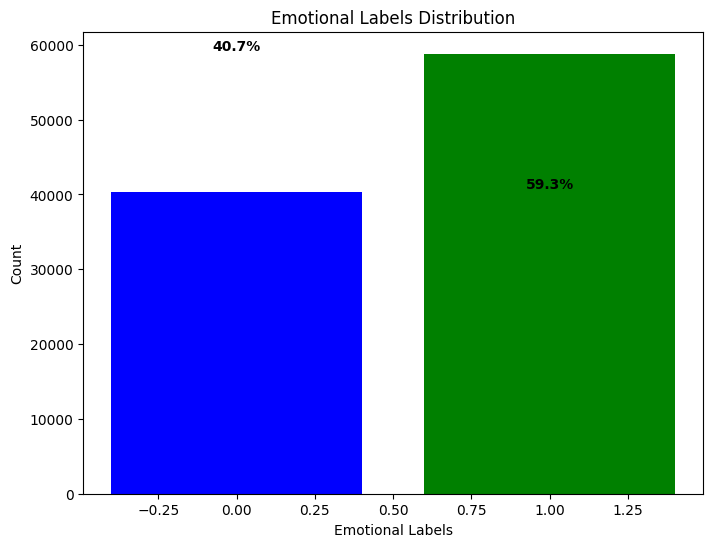

총 샘플의 수 : 99179


In [ ]:
# "Emotional labels" 컬럼의 분포를 계산하여 시리즈로 저장
label_counts = df["Emotional_labels"].value_counts()

# 전체 데이터 개수를 구합니다.
total_count = len(df)

# 각 레이블의 백분율을 계산합니다.
label_percentages = (label_counts / total_count) * 100

# 막대 그래프를 그리기 위한 색상 설정 (긍정: 초록, 부정: 파랑, 중립: 빨강)
colors = ['green', 'blue', 'red']

# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts, color=colors)
plt.xlabel('Emotional Labels')
plt.ylabel('Count')
plt.title('Emotional Labels Distribution')

# 백분율 표시를 위해 각 막대에 텍스트 추가
for i, v in enumerate(label_counts):
    percentage_text = f'{label_percentages[i]:.1f}%'
    plt.text(i, v, percentage_text, ha='center', va='bottom', fontweight='bold')

plt.show()
print('총 샘플의 수 :',len(df))

In [ ]:
print(df.groupby('Emotional_labels').size().reset_index(name = 'count'))

   Emotional_labels  count
0                 0  40375
1                 1  58804


In [ ]:
# train_data의 'document' 컬럼에서 영어와 공백을 제외하고 모두 제거합니다.
df['text_wo_stopfreqrare'] = df['text_wo_stopfreqrare'].apply(lambda x: re.sub("[^a-zA-Z ]", "", x))

In [ ]:
df[["text_wo_stopfreqrare", "Emotional_labels"]]

,text_wo_stopfreqrare,Emotional_labels
0,understand would like assist would need priva...,0
1,sprintcare propose,1
2,sprintcare sent several private messages one r...,1
3,send Private Message assist Just click Messag...,0
4,sprintcare,1
...,...,...
99995,understand received different product ordered...,0
99996,AmazonHelp already raised issue see happen next,1
99997,If youve shared details via link Well certain...,0
99998,AmazonHelp It great ur side ur pre scripted n ...,0


In [ ]:
new_df = df[["text_wo_stopfreqrare", "Emotional_labels"]]

In [ ]:
new_df

,text_wo_stopfreqrare,Emotional_labels
0,understand would like assist would need priva...,0
1,sprintcare propose,1
2,sprintcare sent several private messages one r...,1
3,send Private Message assist Just click Messag...,0
4,sprintcare,1
...,...,...
99995,understand received different product ordered...,0
99996,AmazonHelp already raised issue see happen next,1
99997,If youve shared details via link Well certain...,0
99998,AmazonHelp It great ur side ur pre scripted n ...,0


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_df['text_wo_stopfreqrare'])

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60883
등장 빈도가 1번 이하인 희귀 단어의 수: 38459
단어 집합에서 희귀 단어의 비율: 63.168700622505455
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5804190856381055


In [ ]:
# 전체 단어 개수 중 빈도수 1이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22425


In [ ]:
# Tokenizer 객체 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_df['text_wo_stopfreqrare'])  # 'text_wo_stopfreqrare' 컬럼으로부터 단어 집합 생성
new_df['text_wo_stopfreqrare'] = tokenizer.texts_to_sequences(new_df['text_wo_stopfreqrare'])

In [ ]:
print(new_df['text_wo_stopfreqrare'][:3])

0    [163, 16, 5, 50, 16, 19, 787, 3499, 52, 50]
1                                    [456, 6358]
2      [456, 101, 897, 787, 550, 29, 1376, 1512]
Name: text_wo_stopfreqrare, dtype: object


In [ ]:
new_df_y_train = np.array(new_df['Emotional_labels'])

In [ ]:
# 빈도수 낮은 단어를 삭제한 시퀀스 생성
sequences_wo_low_freq = [seq for i, seq in enumerate(sequences) if i not in drop_train]

# 빈도수 낮은 단어를 삭제한 new_df 데이터프레임 생성
new_df = new_df.drop(index=drop_train)
print(len(new_df['text_wo_stopfreqrare']))

99179


리뷰의 최대 길이 : 54
리뷰의 평균 길이 : 10.846583393078935


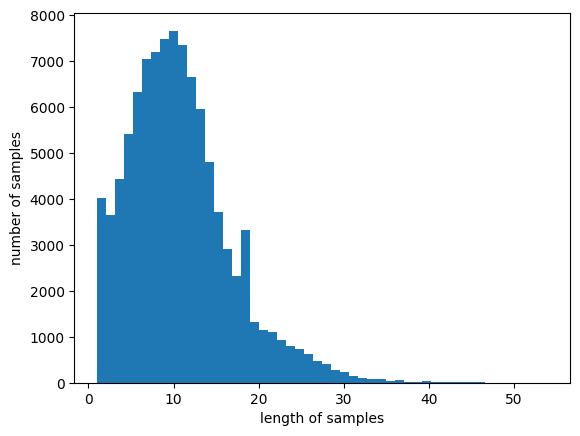

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in new_df2))
print('리뷰의 평균 길이 :',sum(map(len, new_df2))/len(new_df2))
plt.hist([len(review) for review in new_df2], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 25
below_threshold_len(max_len, new_df2)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 97.2624733669255


In [ ]:
# 시퀀스들의 리스트인 sequences_wo_low_freq를 new_df에 저장합니다.
new_df['text_wo_stopfreqrare'] = sequences_wo_low_freq

# 시퀀스를 패딩하여 모든 샘플의 길이를 max_len으로 맞춥니다.
max_len = 25  # 예시로 100으로 지정했습니다. 원하는 길이로 변경 가능합니다.
new_df['text_wo_stopfreqrare'] = pad_sequences(new_df['text_wo_stopfreqrare'], maxlen=max_len)

In [ ]:
# Tokenizer 객체 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_df['text_wo_stopfreqrare'])

# 단어 집합의 크기 확인
vocab_size = len(tokenizer.word_index) + 1

# 'text_wo_stopfreqrare' 데이터를 정수 인코딩하여 리스트로 변환
sequences = tokenizer.texts_to_sequences(new_df['text_wo_stopfreqrare'])

# 시퀀스를 패딩하여 모든 샘플의 길이를 동일하게 맞춥니다.
max_len = 100
X = pad_sequences(sequences, maxlen=max_len)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(new_df['Emotionallabels'], num_classes=3)

# 전체 데이터의 80%를 훈련 데이터로, 나머지 20%를 검증 데이터로 나눕니다.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 컴파일
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
  10/1240 [..............................] - ETA: 14s - loss: 0.6882 - acc: 0.5672

InvalidArgumentError: ignored